# Cyclical features in time series forecasting

Cyclical features play an important role in time series prediction because they capture recurring patterns or oscillations within a data set. These patterns repeat at fixed intervals, and effective incorporation of cyclical features into a machine learning model requires careful pre-processing and feature engineering.

Due to the circular nature of cyclical features, it is not recommended to use them directly as numerical inputs in a machine learning model. Instead, they should be encoded in a format that captures their cyclical behaviour. There are several common encoding techniques:

+ One-hot encoding: If the cyclical feature consists of distinct categories, such as seasons or months, one-hot encoding can be used. This approach creates binary variables for each category, allowing the model to understand the presence or absence of specific categories.

+ Trigonometric coding: For periodic features such as time of day or day of week, trigonometric functions such as sine and cosine can be used for coding. By mapping the cyclic feature onto a unit circle, these functions preserve the cyclic relationships. In addition, this method introduces only two additional features, making it an efficient coding technique.

+ Basis functions: Basis functions are mathematical functions that span a vector space and can be used to represent other functions within that space. When using basis functions, the cyclic feature is transformed into a new set of features based on the chosen basis functions. Some commonly used basis functions for encoding cyclic features include Fourier basis functions, B-spline basis functions and Gaussian basis functions. B-Splines are a way to approximate non-linear functions by using a piece-wise combination of polynomials.

By applying these encoding techniques, cyclic features can be effectively incorporated into a machine learning model, allowing it to capture and exploit the valuable recurring patterns present in time series data.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; padding-left: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">🖉 Note</b>
</p>

The following examples are is inspired by <a href="https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py">Time-related feature engineering</a>, <a href="https://scikit-lego.netlify.app/preprocessing.html#Repeating-Basis-Function-Transformer">scikit-lego’s documentation</a> and <a href="https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/">Three Approaches to Encoding Time Information as Features for ML Models By Eryk Lewinson</a>.
</div>
<br><br>

## Libraries

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import SplineTransformer
from sklearn.compose import make_column_transformer
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

## Data

In [2]:
# Downloading data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
data = pd.read_csv(url)

# Data preparation
# ==============================================================================
data = data[['date_time', 'users']]
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
data = data.resample(rule='D', closed='left', label ='left').sum()
data = data.asfreq('D')
data = data.sort_index()

# Create month
# ==============================================================================
data['month'] = data.index.month
data.head(3)

,users,month
date_time,,
2011-01-01,985.0,1
2011-01-02,804.0,1
2011-01-03,1353.0,1


In [3]:
# Split train-test
# ==============================================================================
data = data.loc[: '2012-06-30 23:00:00'].copy()
end_train = '2012-02-28 23:59:00'
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]

print(f"Dates train : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates test  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train : 2011-01-01 00:00:00 --- 2012-02-28 00:00:00  (n=424)
Dates test  : 2012-02-29 00:00:00 --- 2012-06-30 00:00:00  (n=123)


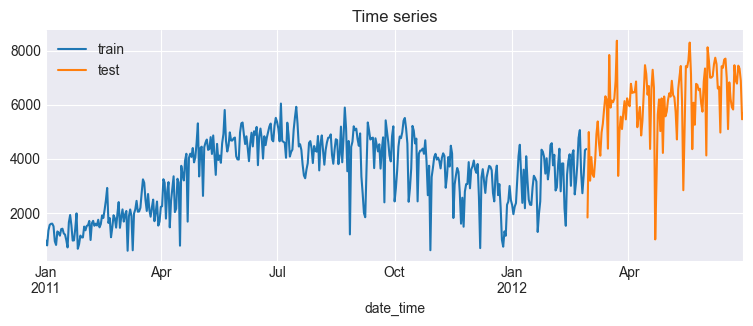

In [4]:
# Plot time series
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 3))
data_train['users'].plot(title="Time series", label="train", ax=ax)
data_test['users'].plot(title="Time series", label="test", ax=ax)
ax.legend();

## One hot encoding

In [5]:
# One hot encoding of week_day and hour_day
# ==============================================================================
one_hot_encoder = make_column_transformer(
                        (
                            OneHotEncoder(sparse_output=False, drop='if_binary'),
                            ['month'],
                        ),
                        remainder="passthrough",
                        verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

data_encoded_oh = one_hot_encoder.fit_transform(data)
data_encoded_oh.head(3)

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,users
date_time,,,,,,,,,,,,,
2011-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,985.0
2011-01-02,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,804.0
2011-01-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1353.0


## Sine-Cosine encoding

In [6]:
# Cyclical encoding with sine/cosine transformation
# ==============================================================================
def sin_transformer(period):
	"""
	Returns a transformer that applies sine transformation to a variable using
	the specified period.
	"""
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
	"""
	Returns a transformer that applies cosine transformation to a variable using
	the specified period.
	"""
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

data_encoded_sin_cos = data.copy()
data_encoded_sin_cos["month_sin"] = sin_transformer(12).fit_transform(data_encoded_sin_cos['month'])
data_encoded_sin_cos["month_cos"] = cos_transformer(12).fit_transform(data_encoded_sin_cos['month'])
data_encoded_sin_cos.head()

,users,month,month_sin,month_cos
date_time,,,,
2011-01-01,985.0,1,0.5,0.866025
2011-01-02,804.0,1,0.5,0.866025
2011-01-03,1353.0,1,0.5,0.866025
2011-01-04,1563.0,1,0.5,0.866025
2011-01-05,1602.0,1,0.5,0.866025


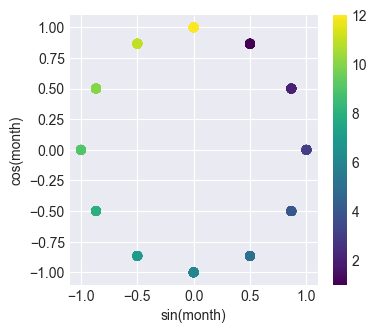

In [7]:
# Plot of the transformation
# ==============================================================================
fig, ax = plt.subplots(figsize=(4., 3.5))
sp = ax.scatter(
        data_encoded_sin_cos["month_sin"],
        data_encoded_sin_cos["month_cos"],
        c=data_encoded_sin_cos["month"],
        cmap='viridis'
     )
ax.set(
    xlabel="sin(month)",
    ylabel="cos(month)",
)
_ = fig.colorbar(sp)
data_encoded_sin_cos = data_encoded_sin_cos.drop(columns='month')

## B-splines functions

In [8]:
# Create month
# ==============================================================================
data['day_of_year'] = data.index.day_of_year
data.head(3)

,users,month,day_of_year
date_time,,,
2011-01-01,985.0,1,1
2011-01-02,804.0,1,2
2011-01-03,1353.0,1,3


In [9]:
# B-spline functions
# ==============================================================================
def spline_transformer(period, degree=3, extrapolation="periodic"):
    """
    Returns a transformer that applies B-spline transformation.
    """
    return SplineTransformer(
                degree=degree,
                n_knots=period+1,
                knots='uniform',
                extrapolation=extrapolation,
                include_bias=True
            ).set_output(transform="pandas")

splines_month = spline_transformer(period=12).fit_transform(data[['day_of_year']])

The plot below depicts 24 radial basis functions generated using the hour number as input, with each curve representing the proximity to a specific hour of the day.

C:\Users\jaesc2\AppData\Local\Temp\ipykernel_13300\3286657084.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  splines_month.head(365).plot(


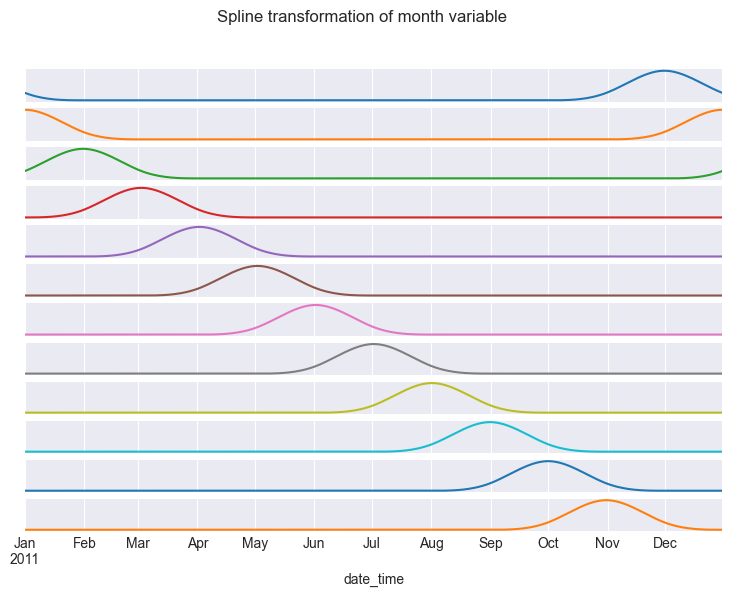

In [10]:
# Plot of the B-splines functions for the first 24 hours
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 6))
splines_month.head(365).plot(
    ax       = ax,
    subplots = True,
    sharex   = True,
    legend   = False,
    yticks   = [],
    title    = 'Spline transformation of month variable'
);

In [11]:
# Encoded data
# ==============================================================================
data_encoded_splines = pd.concat([data, splines_month], axis=1)
data_encoded_splines = data_encoded_splines.drop(columns=['day_of_year', 'month'])
data_encoded_splines.head(24)

,users,day_of_year_sp_0,day_of_year_sp_1,day_of_year_sp_2,day_of_year_sp_3,day_of_year_sp_4,day_of_year_sp_5,day_of_year_sp_6,day_of_year_sp_7,day_of_year_sp_8,day_of_year_sp_9,day_of_year_sp_10,day_of_year_sp_11
date_time,,,,,,,,,,,,,
2011-01-01,985.0,0.166667,0.666667,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-02,804.0,0.150721,0.665598,0.183676,0.000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-03,1353.0,0.135826,0.662463,0.201664,0.000048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-04,1563.0,0.121946,0.657369,0.220524,0.000161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-05,1602.0,0.109045,0.650424,0.240149,0.000382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-06,1608.0,0.097088,0.641735,0.260430,0.000746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-07,1511.0,0.086039,0.631411,0.281261,0.001290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-08,959.0,0.075861,0.619557,0.302534,0.002048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-09,822.0,0.066520,0.606282,0.324141,0.003057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Compare modeling results

In [12]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = HistGradientBoostingRegressor(random_state=123),
                 lags = 1
             )

In [13]:
# Train and validate a forecaster using each encoding method
# ==============================================================================
datasets = [data_encoded_oh, data_encoded_sin_cos, data_encoded_splines]
encoding_methods = ['one hot encoding', 'sine/cosine encoding', 'spline encoding']

for i, data_encoded in enumerate(datasets):

    metric, predictions = backtesting_forecaster(
                              forecaster         = forecaster,
                              y                  = data_encoded['users'],
                              exog               = data_encoded.drop(columns='users'),
                              initial_train_size = len(data_encoded.loc[:end_train]),
                              fixed_train_size   = False,
                              steps              = 90,
                              refit              = False,
                              metric             = 'mean_squared_error',
                              verbose            = False, # Change to True to see detailed information,
                              show_progress      = False
                          )

    print(f"Backtest error using {encoding_methods[i]}: {metric:.2f}") 

Backtest error using one hot encoding: 6125347.06
Backtest error using sine/cosine encoding: 8294756.82
Backtest error using spline encoding: 6456321.52


%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>